In [217]:
#!pip install kaggle 
#!pip install missingno
#!pip install scikit-image
!pip install rapidfuzz

Defaulting to user installation because normal site-packages is not writeable


In [218]:
import requests
import pandas as pd
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date

from skimage.feature import shape_index
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

import os
import unicodedata
import difflib

import re
from rapidfuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


from kaggle.api.kaggle_api_extended import KaggleApi

In [219]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [220]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Tam yol
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)

def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadı: {dataset}")
        return None

In [221]:
df_customers = load(customers_path)
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [222]:
df_geo_avg = load(geolocation_path)
df_geo_avg.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.546,-46.639,sao paulo,SP
1,1046,-23.546,-46.645,sao paulo,SP
2,1046,-23.546,-46.643,sao paulo,SP
3,1041,-23.544,-46.639,sao paulo,SP
4,1035,-23.542,-46.642,sao paulo,SP


In [223]:
# zip prefix bazında özet tablo
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # kaç farklı şehir var
        state_count=("geolocation_state", "nunique"),   # kaç farklı eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satır sayısı (koordinat sayısı)
        lat_std=("geolocation_lat", "std"),             # enlem sapması
        lng_std=("geolocation_lng", "std")              # boylam sapması
    )
    .reset_index()
)

summary.head()


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
0,1001,2,1,26,0.001,0.000
1,1002,2,1,13,0.001,0.001
2,1003,2,1,17,0.000,0.001
3,1004,2,1,22,0.001,0.000
4,1005,2,1,25,0.000,0.001


In [224]:
# %95 eşiklerini hesapla
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# geniş alan zip’leri seç
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

print("Lat std için %95 eşik:", lat_thresh)
print("Lng std için %95 eşik:", lng_thresh)
print("Eşik üzerinde kaç kayıt var:", len(wide_zips))
wide_zips.head(10)



Lat std için %95 eşik: 0.04056525284991052
Lng std için %95 eşik: 0.045473794164270054
Eşik üzerinde kaç kayıt var: 1272


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
130,1239,2,1,152,0.012,0.066
202,1417,2,1,86,0.026,0.079
215,1430,2,1,11,0.145,0.013
216,1431,2,1,13,0.117,0.011
257,1513,1,1,24,0.023,0.072
406,2169,2,1,45,0.106,0.071
458,2237,1,1,8,0.136,0.045
508,2290,2,1,3,0.109,0.047
531,2323,2,1,56,0.044,0.053
532,2324,2,1,48,0.087,0.033


In [225]:
# summary tablosundan gerekli sütunları alıyoruz
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Durum sütunu ekleyelim
def zip_type(row):
    if row['state_count'] > 1:
        return 'Farklı eyaletlerde'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Aynı eyalette farklı şehirler'
    else:
        return 'Tek şehir, tek eyalet'

zip_summary['type'] = zip_summary.apply(zip_type, axis=1)

# Sıralama: önce eyalet sayısına göre, sonra şehir sayısına göre
zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

# Örnek olarak ilk 20 satırı göster
zip_summary_sorted.head(20)

,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde
8,6900,5,1,Aynı eyalette farklı şehirler
9,13318,5,1,Aynı eyalette farklı şehirler


In [226]:
# Aynı eyalette birden fazla şehir
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [227]:
# Farklı eyaletleri kapsayan zip kodları
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# İlk 10 satırı göster
multi_state_zips.head(10)

# İstersen tüm listeyi görmek için:
multi_state_zips


,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde


In [228]:
# Farklı eyaletleri kapsayan zip kodları ve eyalet isimleri
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states


,geolocation_zip_code_prefix,geolocation_state_x,geolocation_state_y
0,2116,2,"[SP, RN]"
1,4011,2,"[SP, AC]"
2,21550,2,"[RJ, AC]"
3,23056,2,"[RJ, AC]"
4,72915,2,"[GO, DF]"
5,78557,2,"[MT, RO]"
6,79750,2,"[MS, RS]"
7,80630,2,"[PR, SC]"


In [229]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

,geolocation_zip_code_prefix,geolocation_city_x,geolocation_city_y
0,1001,2,"[sao paulo, são paulo]"
1,1002,2,"[sao paulo, são paulo]"
2,1003,2,"[sao paulo, são paulo]"
3,1004,2,"[sao paulo, são paulo]"
4,1005,2,"[sao paulo, são paulo]"


In [230]:
# Her zip için state ve city bilgisi
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # her zip içindeki toplam farklı şehir sayısı
    )
    .reset_index()
)

# Sıralama: önce state_count, sonra max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_info_sorted.head(20)



,geolocation_zip_code_prefix,state_count,states,max_city_count
0,72915,2,"[GO, DF]",3
1,2116,2,"[SP, RN]",2
2,4011,2,"[SP, AC]",2
3,78557,2,"[MT, RO]",2
4,80630,2,"[PR, SC]",2
5,21550,2,"[RJ, AC]",1
6,23056,2,"[RJ, AC]",1
7,79750,2,"[MS, RS]",1
8,6900,1,[SP],5
9,13318,1,[SP],5


In [231]:
df_orderitems = load(orderitems_path)
df_orderitems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900,13.290
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.900,19.930
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000,17.870
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.990,12.790
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.900,18.140


In [232]:
df_orderpayments = load(orderpayments_path)
df_orderpayments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.330
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.390
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.710
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.780
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.450


In [233]:
df_orderreviews = load(orderreviews_path)
df_orderreviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [234]:
df_orders = load(orders_path)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [235]:
df_products = load(products_path)
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [236]:
df_sellers = load(sellers_path)
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### Farkli yazim sekilleri nedeniyle tekrar eden ayni sehir ve eyaletlerin tespiti

In [237]:
# 1️⃣ Gelişmiş şehir normalizasyonu
def normalize_city_advanced(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Aksanları kaldır
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Nokta, tire, apostrof, boşluk gibi karakterleri kaldır
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name

In [238]:
# 2️⃣ Benzer şehirleri gruplayıp tekilleştirme
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # ilk gördüğünü referans al
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping

In [239]:
# 3. Eyalet bazında şehir eşleştirme (multithreading)
def deduplicate_state(row, state_col, threshold):
    state = row[state_col]
    city_list = list(row['cities'])
    mapping = deduplicate_names_rf(city_list, threshold)
    return {(state, k): v for k, v in mapping.items()}

In [240]:
# 4. Ana fonksiyon (şehir + eyalet)

def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    Tüm şehir isimlerini normalize eder ve benzer şehirleri tekilleştirir.
    """
    # Normalize edilmiş şehir sütunu
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # Eyalet bazında şehir listesi
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Eyalet bazlı eşleşmeler
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Orijinal tabloyu güncelle
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Geçici sütunu kaldır
    df = df.drop(columns=['city_norm'])
    
    return df

In [241]:
# geolocation tablosu için
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [242]:
# Customers tablosu için
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')


In [243]:
# Sellers tablosu için
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Temizleme işleminden sonra hala tekrar eden şehir isimleri kaldı mı kontrol

In [244]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Temizlenmiş tabloda hala birbirine benzer şehir var mı diye kontrol eder.
    """
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("✅ Hiç tekrar eden veya benzer şehir kalmadı.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nEyalet: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (benzerlik: {dup[2]:.2f})")



In [245]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [246]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [247]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


# DATA MODELING

-----------------------------
️1-  Basit sayısal ID oluşturma fonksiyonu
-----------------------------

In [248]:
# Prefiksli ID oluşturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map

# Prefiksli ID oluşturma (ID olmayan tablolar)
def create_prefixed_id_no_col(df, new_id_col, prefix):
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


️2- PK’ları Prefiksli ID’ye Çevirme ve Mapping Saklama
-----------------------------


In [249]:

# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (ID olmayan ama ürün sayısı kolonu korunacak)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # PK değil
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")
# Order Payments
df_orderpayments= create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")
# Geolocation (ID yok)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")


In [250]:
# Orders → customer_id_pref ekle
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Order Items → order_id_pref, product_id_pref, seller_id_pref ekle
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Order Payments → order_id_pref ekle
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)


In [251]:
# 1. Eşsiz customer_unique_id listesi
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Yeni ID oluştur
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Orijinal tabloya merge ile ekle
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [252]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_id_pref,cusUni
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,CUS001,CUSUNI0001
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,saobernardodocampo,SP,CUS002,CUSUNI0002
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,saopaulo,SP,CUS003,CUSUNI0003
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogidascruzes,SP,CUS004,CUSUNI0004
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,CUS005,CUSUNI0005


In [253]:
# 1. Her customer_unique_id kaç farklı cusUni ile eşleşmiş 
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Eğer her customer_unique_id yalnızca bir cusUni ile eşleşmişse tamamdır
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.")
else:
    print("Dikkat! Bazı müşteri unique ID’leri birden fazla yeni ID ile eşleşmiş:")
    print(problem_customers)



Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.


In [254]:
customer_id = "1b6c7548a2a1f9037c1fd3ddfed95f33"

customer_info = df_customers[df_customers['customer_unique_id'] == customer_id]

customer_info


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_id_pref,cusUni
7012,53e16f83735cfe02bf83ef6481ca241e,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS7013,CUSUNI6996
12164,95b9cacc4bc81c3a0a33967bcde6fcd8,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS12165,CUSUNI6996
16824,41a16488effb86580d7a89f8aa19a03b,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS16825,CUSUNI6996
24987,fff7466a253c0e59499ea943462c10f9,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS24988,CUSUNI6996
50663,c2ff01bd4fa72f9487ee397f6c5989d2,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS50664,CUSUNI6996
65287,9a4578c9dd9dce6517d583cb5eca0276,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS65288,CUSUNI6996
66714,ee5c2e36a79081c2440e61990ec2f3af,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS66715,CUSUNI6996


Customers ve Sellers  tablosuna geolocation_id_pref ekle

Artık zip code ve city/state kolonlarını customers & sellers'tan silebiliriz

Orijinal ID’leri sil

In [255]:
# Orijinal ID kolonları
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id", "unique_id"],
    "orders": ["order_id", "customer_id", "unique_id"],
    "order_items": ["order_id", "product_id", "seller_id", "unique_id"],
    "products": ["product_id", "unique_id"],
    "order_payments": ["orderpayment_id", "order_id", "unique_id"],
    "df_geo_avg": ["unique_id"]
}

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]
  

Prefiksli ID’leri başa taşı

In [256]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=[]):
    df = df.copy()
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]

# Başta prefiksli ID, FK’lar da başa
df_customers = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments = move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")


In [257]:
df_geo_avg.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [258]:
df_geolocation = df_geo_avg

In [259]:

# 1. GEO tablosundan ortalama koordinat çıkar (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. CUSTOMERS tablosuna ortalama koordinat ekle
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temp kolon gerekmez

# 3. SELLERS tablosuna ortalama koordinat ekle
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

# Artık:
# df_geo_full  -> ham geo data (zip + lat + lng + pk)
# geo_avg      -> zip bazlı ortalama koordinatlar
# df_customers -> müşteri tablosu + ortalama koordinatlar
# df_sellers   -> satıcı tablosu + ortalama koordinatlar


In [260]:
df_geo_avg.head()

,zip_prefix,lat_avg,lng_avg
0,1001,-23.550,-46.634
1,1002,-23.548,-46.635
2,1003,-23.549,-46.636
3,1004,-23.550,-46.635
4,1005,-23.549,-46.637


In [261]:
df_customers = df_customers.rename(columns={"customer_id_pref": "customer_order_id"})

In [262]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [263]:
df_customers.head()

,customer_order_id,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg
0,CUS001,14409,franca,SP,CUSUNI0001,-20.498,-47.397
1,CUS002,9790,saobernardodocampo,SP,CUSUNI0002,-23.728,-46.543
2,CUS003,1151,saopaulo,SP,CUSUNI0003,-23.532,-46.656
3,CUS004,8775,mogidascruzes,SP,CUSUNI0004,-23.500,-46.185
4,CUS005,13056,campinas,SP,CUSUNI0005,-22.975,-47.143


In [264]:
df_geolocation.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [265]:
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [266]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [267]:
df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


In [268]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})
df_orders.head()

,order_id_pref,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,ORD001,CUS70297,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,ORD002,CUS77028,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,ORD003,CUS555,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,ORD004,CUS61082,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ORD005,CUS67264,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [269]:
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [270]:
df_products.head()

,product_id_pref,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,PRO001,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,PRO002,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,PRO003,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,PRO004,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,PRO005,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [271]:
df_orderpayments.head() 

,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
0,PAY001,ORD75269,1,credit_card,8,99.330
1,PAY002,ORD98161,1,credit_card,1,24.390
2,PAY003,ORD43930,1,credit_card,1,65.710
3,PAY004,ORD64933,1,credit_card,8,107.780
4,PAY005,ORD12703,1,credit_card,2,128.450


### Data tablolari yeni klasore (cleaned_data_with_prefix_id) eklenmis durumda.
### Kodu yeniden calistirirsaniz ikinci bir data klasoru olusturulmaz ve 
### Bu klasor eger olusturulmus durumda ise tablolar bu klasore olustururlur.
### Mevcut tablolar onceden var ise , guncellenir. 
### Klasor yok ise bastan olusturulur...

In [272]:

# ❗ Not: Bu kod her çalıştırıldığında yeni CSV dosyaları oluşturur.
# Eğer mevcut temizlenmiş datasetlerin üzerine yazmak istemiyorsanız çalıştırmayın.
# Bu kodun amacı: Prefiksli ID'lerle güncellenmiş tüm tabloları CSV olarak dışarı aktarmaktır.

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation" : df_geolocation
}

proceed = input("CSV dosyalarını yeniden oluşturmak istediğinize emin misiniz? (E/H): ")
if proceed.upper() != 'E':
    print("İşlem iptal edildi.")
else:
    base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")
    os.makedirs(base_path, exist_ok=True)
    
    for name, df in dfs.items():
        file_path = os.path.join(base_path, f"{name}.csv")
        df.to_csv(file_path, index=False)
        print(f"{file_path} kaydedildi.")



İşlem iptal edildi.


### Yeni Olusturulan Dosya Yollari
#### notebook yeniden baslatildiginda direk buradan tablolar yuklenebilir..

In [273]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Tam yol
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [274]:
def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadı: {dataset}")
        return None

In [275]:
df_customers = load(new_customers_path)

df_customers.head()

,customer_id_pref,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg
0,CUS001,14409,franca,SP,CUSUNI0001,-20.498,-47.397
1,CUS002,9790,sao bernardo do campo,SP,CUSUNI0002,-23.728,-46.543
2,CUS003,1151,sao paulo,SP,CUSUNI0003,-23.532,-46.656
3,CUS004,8775,mogi das cruzes,SP,CUSUNI0004,-23.500,-46.185
4,CUS005,13056,campinas,SP,CUSUNI0005,-22.975,-47.143


In [276]:
df_geolocation = load(new_geolocation_path)
df_geolocation.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,sao paulo,SP
1,GEO002,1046,-23.546,-46.645,sao paulo,SP
2,GEO003,1046,-23.546,-46.643,sao paulo,SP
3,GEO004,1041,-23.544,-46.639,sao paulo,SP
4,GEO005,1035,-23.542,-46.642,sao paulo,SP


In [277]:
df_orderitems = load(new_orderitems_path)
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [278]:
df_orderpayments = load(new_orderpayments_path)
df_orderpayments.head()

,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
0,PAY001,ORD75269,1,credit_card,8,99.330
1,PAY002,ORD98161,1,credit_card,1,24.390
2,PAY003,ORD43930,1,credit_card,1,65.710
3,PAY004,ORD64933,1,credit_card,8,107.780
4,PAY005,ORD12703,1,credit_card,2,128.450


In [279]:
df_orders = load(new_orders_path)
df_orders.head()

,order_id_pref,customer_id_pref,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,ORD001,CUS70297,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,ORD002,CUS77028,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,ORD003,CUS555,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,ORD004,CUS61082,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ORD005,CUS67264,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [280]:
df_products = load(new_products_path)
df_products.head()

,product_id_pref,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,PRO001,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,PRO002,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,PRO003,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,PRO004,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,PRO005,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [281]:
df_sellers = load(new_sellers_path)

df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogi guacu,SP,-22.383,-46.948
2,SEL003,20031,rio de janeiro,RJ,-22.910,-43.178
3,SEL004,4195,sao paulo,SP,-23.657,-46.613
4,SEL005,12914,braganca paulista,SP,-22.965,-46.534


## mevcut dimension tablolarını kullanarak fact_order_shipments tablosu

In [282]:
# 1️⃣ Order Items + Orders
fact_df = df_orderitems.merge(
    df_orders,
    on='order_id_pref',
    how='left'
)

# 2️⃣ Customers ekleme
fact_df = fact_df.merge(
    df_customers[['customer_id_pref','customer_zip_code_prefix',
                  'customer_city','customer_state','cusUni',
                  'customer_lat_avg','customer_lng_avg']],
    on='customer_id_pref',
    
    how='left'
)

# 3️⃣ Sellers ekleme
fact_df = fact_df.merge(
    df_sellers[['seller_id_pref','seller_zip_code_prefix',
                'seller_city','seller_state',
                'seller_lat_avg','seller_lng_avg']],
    on='seller_id_pref',
    how='left'
)

# 4️⃣ Products ekleme
fact_df = fact_df.merge(
    df_products[['product_id_pref','product_category_name',
                 'product_name_lenght','product_description_lenght',
                 'product_photos_qty','product_weight_g',
                 'product_length_cm','product_height_cm','product_width_cm']],
    on='product_id_pref',
    how='left'
)

# 5️⃣ Payments ekleme
fact_df = fact_df.merge(
    df_orderpayments[['order_id_pref','payment_type',
                      'payment_installments','payment_value']],
    on='order_id_pref',
    how='left'
)

# 6️⃣ Tarih kolonlarını datetime tipine çevir
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_cols:
    fact_df[col] = pd.to_datetime(fact_df[col], errors='coerce')

In [283]:
#  Hazırlık ve teslim sürelerini hesapla
fact_df['prep_time'] = (fact_df['order_delivered_carrier_date'] - fact_df['order_approved_at']).dt.days
fact_df['shipping_time'] = (fact_df['order_delivered_customer_date'] - fact_df['order_delivered_carrier_date']).dt.days
fact_df['estimated_time'] = (fact_df['order_estimated_delivery_date'] - fact_df['order_approved_at']).dt.days

In [284]:
#  Null değer kontrolü 
print(fact_df[['prep_time', 'shipping_time', 'estimated_time']].isnull().sum())

prep_time         1260
shipping_time     2568
estimated_time      15
dtype: int64


In [285]:
print(fact_df.shape[0])
fact_df[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100


117604


prep_time        1.071
shipping_time    2.184
estimated_time   0.013
dtype: float64

In [286]:
#  Gecikme hesaplaması
fact_df['delay_days'] = (fact_df['order_delivered_customer_date'] - fact_df['order_estimated_delivery_date']).dt.days
fact_df['delay_days'] = fact_df['delay_days'].apply(lambda x: max(0, x))
fact_df['is_late'] = fact_df['delay_days'].apply(lambda x: 1 if x > 0 else 0)


In [287]:
#  Gecikme sınıfı
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_df['delay_class'] = fact_df['delay_days'].apply(classify_delay)

In [288]:
#  Müşteri-satıcı mesafesi
#!pip install haversine

from haversine import haversine, Unit
# haversine, genellikle iki koordinat arasındaki mesafeyi (km veya mil cinsinden) hesaplamak için kullanılır.
def compute_distance(row):
    if pd.isna(row['customer_lat_avg']) or pd.isna(row['seller_lat_avg']):
        return np.nan
    return haversine((float(row['customer_lat_avg']), float(row['customer_lng_avg'])),
                     (float(row['seller_lat_avg']), float(row['seller_lng_avg'])))

fact_df['distance_km'] = fact_df.apply(compute_distance, axis=1)

In [289]:
#  Aynı siparişteki satıcı sayısı
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)
fact_df = fact_df.merge(seller_count, on='order_id_pref', how='left')

In [290]:
#  İlgili sütunları seçerek final fact tablosu
fact_order_shipments = fact_df[[
    'customer_id_pref', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_type', 'payment_value', 'seller_count_per_order' 
]]

In [291]:
fact_order_shipments.head()

,customer_id_pref,order_id_pref,seller_id_pref,product_id_pref,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,prep_time,shipping_time,estimated_time,delay_days,delay_class,is_late,distance_km,payment_type,payment_value,seller_count_per_order
0,CUS65558,ORD85268,SEL514,PRO25866,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29,6.000,1.000,15.000,0.000,0,0,301.505,credit_card,72.190,1
1,CUS34266,ORD71854,SEL472,PRO27231,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,2017-05-15,8.000,8.000,18.000,0.000,0,0,585.565,credit_card,259.830,1
2,CUS34956,ORD6299,SEL1825,PRO22625,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,2018-02-05,1.000,6.000,21.000,0.000,0,0,312.344,credit_card,216.870,1
3,CUS51764,ORD22551,SEL2024,PRO15404,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,2018-08-20,2.000,4.000,11.000,0.000,0,0,293.169,credit_card,25.780,1
4,CUS7603,ORD5248,SEL1598,PRO8863,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,2017-03-17,11.000,13.000,40.000,0.000,0,0,646.164,credit_card,218.040,1


In [292]:
fact_order_shipments.to_csv('fact_order_shipments.csv', index=False)

#### 1. customer_order_id

Anlamı: Her müşteri için önceden oluşturulmuş benzersiz kimlik.

Katkısı: Gecikme tahminini müşteri davranışına göre iyileştirebilirsin. Örneğin bazı müşteriler sürekli belirli satıcılardan veya belirli bölgelerden alışveriş yapıyor olabilir.

#### 2. order_id_pref

Anlamı: Her sipariş için benzersiz kimlik.

Katkısı: Tahmin modeli sipariş bazlı olacaksa bu kolon gerekli. Sipariş düzeyinde gecikme sürelerini hesaplamak için kullanılır.

#### 3. seller_id_pref

Anlamı: Siparişi gönderen satıcının kimliği.

Katkısı: Satıcı performansı gecikmeyi etkileyebilir. Bazı satıcılar daha hızlı veya yavaş teslimat yapabilir. Modelin “satıcıya göre gecikme olasılığı” öğrenebilir.

#### 4. product_id_pref

Anlamı: Siparişteki ürünün kimliği.

Katkısı: Ürün boyutu, stok durumu veya paketleme süresi gecikmeyi etkileyebilir. Model bu kolon ile ürün bazlı gecikmeleri öğrenebilir.

#### 5. order_purchase_timestamp

Anlamı: Siparişin verildiği tarih ve saat.

Katkısı: Sezon, hafta içi/sonu, tatil günleri gibi zamansal faktörler gecikmeyi etkileyebilir. Özellikle gün aralıklı gecikme tahmininde çok önemli.

#### 6. order_approved_at

Anlamı: Siparişin onaylandığı tarih ve saat.

Katkısı: Onay ile teslimat arasındaki fark hazırlık süresini (prep_time) etkiler. Modelin “hazırlık süresini” öğrenmesi için kullanılır.

#### 7. order_delivered_customer_date

Anlamı: Siparişin müşteriye ulaştığı tarih.

Katkısı: Hedef değişkenin biri olabilir (delay_days veya is_late). Gecikme süresini hesaplamak için gerekli.

#### 8. order_estimated_delivery_date

Anlamı: Tahmini teslimat tarihi.

Katkısı: Modelin gecikmeyi tahmin etmesi için referans tarih. Ayrıca “estimated_time” kolonunun hesaplanmasında kullanılır.

#### 9. prep_time

Anlamı: Siparişin onaylanması ile kargoya verilmesi arasındaki gün sayısı.

Katkısı: Hazırlık süresi gecikme tahmininde önemli bir feature. Model bunu kullanarak hızlı veya yavaş hazırlık yapan siparişleri öğrenebilir.

#### 10. shipping_time

Anlamı: Kargoya verildikten müşteri teslimine kadar geçen gün sayısı.

Katkısı: Teslimat süresi gecikmesini doğrudan etkiler. Model için kritik feature.

#### 11. estimated_time

Anlamı: Sipariş onayı ile tahmini teslimat arasındaki gün sayısı.

Katkısı: Modelin gecikme oranını tahmin etmesinde referans süre. Gerçek süredeki fark ile gecikmeyi hesaplayabilirsin.

#### 12. delay_days

Anlamı: Tahmini teslimat ile gerçek teslimat arasındaki fark (gün).

Katkısı: Direkt hedef değişken (target) olarak kullanılabilir. Model gecikme süresini gün olarak tahmin edebilir.

#### 13. delay_class

Anlamı: Gecikme sınıflaması (örneğin: 0 = zamanında, 1 = gecikmeli).

Katkısı: İkili sınıflandırma modeli için hedef değişken olarak kullanılabilir. “Gecikmeli mi?” sorusuna cevap verir.

#### 14. is_late

Anlamı: True/False gecikme durumu.

Katkısı: Alternatif olarak sınıflandırma hedefi.

#### 15. distance_km

Anlamı: Satıcı ile müşteri arasındaki mesafe.

Katkısı: Mesafe gecikmeyi etkileyebilir. Uzun mesafe → yüksek gecikme olasılığı. Modelin coğrafi etkileri öğrenmesi için kullanılır.

#### 16. payment_type

Anlamı: Ödeme türü (credit_card, boleto vs.).

Katkısı: Dolaylı olarak gecikmeyi etkileyebilir. Örneğin bazı ödeme tiplerinde onay süresi daha uzun olabilir.

#### 17. payment_value

Anlamı: Siparişin toplam tutarı.

Katkısı: Yüksek değerli siparişler daha dikkatli veya hızlı hazırlanabilir; bu da gecikmeyi etkileyebilir.

#### 18. seller_count_per_order

Anlamı: Aynı siparişte kaç farklı satıcı olduğu.

Katkısı: Birden fazla satıcı olan siparişler gecikmeye daha yatkın olabilir. Özellikle multi-seller siparişler için model bunu öğrenebilir.

In [293]:
total_late_orders = fact_df['is_late'].sum()
total_late_orders

7530

In [294]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]

# delay_days ? (0'dan büyük olanlar gecikmeli)
late_orders = fact_df[fact_df['delay_days'] > 0]
late_orders.head()


,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_id_pref,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_type,payment_installments,payment_value,prep_time,shipping_time,estimated_time,delay_days,is_late,delay_class,distance_km,seller_count_per_order
21,OIT022,ORD35003,PRO7116,SEL988,1,2017-11-27 19:09:02,21.990,11.850,CUS64044,delivered,2017-11-21 18:54:23,2017-11-21 19:09:02,2017-11-22 20:46:54,2017-12-09 17:27:23,2017-12-07,18900,santa cruz do rio pardo,SP,CUSUNI62617,-22.896,-49.624,4160,sao paulo,SP,-23.625,-46.612,telefonia,59.000,540.000,4.000,300.000,17.000,4.000,12.000,credit_card,3.000,33.840,1.000,16.000,15.000,2.000,1,1,318.214,1
40,OIT040,ORD71320,PRO20794,SEL1264,1,2017-04-24 22:25:19,809.100,44.290,CUS27545,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,2017-04-17 13:54:37,2017-05-23 08:32:07,2017-05-19,57250,campo alegre,AL,CUSUNI6726,-9.784,-36.350,35680,itauna,MG,-20.078,-44.576,informatica_acessorios,60.000,2136.000,1.000,3407.000,28.000,22.000,23.000,credit_card,10.000,853.390,10.000,35.000,42.000,4.000,1,2,1445.199,1
48,OIT048,ORD2491,PRO21689,SEL2464,1,2017-11-29 22:38:47,99.000,13.710,CUS507,delivered,2017-11-24 19:19:18,2017-11-24 22:38:47,2017-11-27 12:42:15,2017-12-22 18:37:40,2017-12-14,8072,sao paulo,SP,CUSUNI0507,-23.512,-46.484,14940,ibitinga,SP,-21.757,-48.830,cama_mesa_banho,55.000,312.000,1.000,1550.000,44.000,14.000,34.000,credit_card,4.000,112.710,2.000,25.000,19.000,8.000,1,3,309.811,1
49,OIT049,ORD42206,PRO20437,SEL2364,1,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,sao paulo,SP,CUSUNI68321,-23.493,-46.706,1031,sao paulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,credit_card,2.000,53.540,9.000,1.000,9.000,2.000,1,1,9.095,1
50,OIT050,ORD42206,PRO20437,SEL2364,2,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,sao paulo,SP,CUSUNI68321,-23.493,-46.706,1031,sao paulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,credit_card,2.000,53.540,9.000,1.000,9.000,2.000,1,1,9.095,1


Bu adımda tüm DataFrame’lerdeki kolon isimleri strip() ile temizlendi. Böylece başında/sonunda boşluk olan kolon adları hata çıkarmadan merge edildi.

In [295]:
for df in [df_orders, df_orderitems, df_customers, df_sellers, df_products, df_orderpayments]:
    df.columns = df.columns.str.strip()

### 1- Veri Hazırlık ve Temel İnceleme
* 1.1Fact tablosunu (fact_df) yükle ve ilk birkaç satırı göster
* 1.2 Veri tiplerini kontrol et ve tarih kolonlarını datetime formatına çevir
* 1.3  Eksik değerleri kontrol et
* 1.4  Toplam kayıt sayısını bul
* 1.5 Tekil müşteri - satıcı- sipariş sayısını kontrol et
* 1.6 Sayısal kolonları özetle (prep_time- shipping_time- estimated_time- delay_days- payment_value)


In [298]:
#1.1
fact_df.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_id_pref,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290,CUS65558,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,28013,campos dos goytacazes,RJ,CUSUNI64073,-21.763,-41.310,27277,volta redonda,SP,-22.497,-44.127,cool_stuff,58.000,598.000,4.000,650.000,28.000,9.000,14.000
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930,CUS34266,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,15775,santa fe do sul,SP,CUSUNI33838,-20.221,-50.903,3471,sao paulo,SP,-23.565,-46.519,pet_shop,56.000,239.000,2.000,30000.000,50.000,30.000,40.000
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870,CUS34956,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,35661,para de minas,MG,CUSUNI34511,-19.870,-44.593,37564,borda da mata,MG,-22.263,-46.171,moveis_decoracao,59.000,695.000,2.000,3050.000,33.000,13.000,33.000
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790,CUS51764,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,12952,atibaia,SP,CUSUNI50803,-23.090,-46.612,14403,franca,SP,-20.554,-47.387,perfumaria,42.000,480.000,1.000,200.000,16.000,10.000,15.000
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140,CUS7603,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,13226,varzea paulista,SP,CUSUNI7582,-23.243,-46.828,87900,loanda,PR,-22.929,-53.136,ferramentas_jardim,59.000,409.000,1.000,3750.000,35.000,40.000,30.000


In [300]:
#1.2
print(" Dönüşümden Önceki Mevcut Veri Tipleri")
print(fact_df.dtypes)

# Tarih kolonları
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

# Tarih kolonlarını datetime'a çevir
for col in date_cols:
    if col in fact_df.columns:
        fact_df[col] = pd.to_datetime(fact_df[col], errors='coerce')

print(" Dönüşümden Sonraki Mevcut Veri Tipleri")
print(fact_df[date_cols].dtypes)



 Dönüşümden Önceki Mevcut Veri Tipleri
order_item_pref                   object
order_id_pref                     object
product_id_pref                   object
seller_id_pref                    object
order_item_number                  int64
shipping_limit_date               object
price                            float64
freight_value                    float64
customer_id_pref                  object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
cusUni                            object
customer_lat_avg                 float64
customer_lng_avg                 float64
seller_zip_code_prefix             int64
seller_city                       object
seller_state      

In [301]:
#1.3
# Eksik değerleri kontrol et
null_counts = fact_df.isnull().sum().sort_values(ascending=False)

print("=== Eksik Değer Sayıları (İlk 20 Kolon) ===")
print(null_counts.head(20))

# Eksik değer oranlarını göster:
null_ratio = (fact_df.isnull().mean() * 100).sort_values(ascending=False)

print("\n=== Eksik Değer Oranları (%) (İlk 20 Kolon) ===")
print(null_ratio.head(20))

=== Eksik Değer Sayıları (İlk 20 Kolon) ===
order_delivered_customer_date    2454
product_photos_qty               1603
product_description_lenght       1603
product_name_lenght              1603
product_category_name            1603
order_delivered_carrier_date     1194
customer_lng_avg                  302
customer_lat_avg                  302
seller_lat_avg                    253
seller_lng_avg                    253
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
order_approved_at                  15
seller_state                        0
seller_city                         0
seller_zip_code_prefix              0
order_item_pref                     0
cusUni                              0
dtype: int64

=== Eksik Değer Oranları (%) (İlk 20 Kolon) ===
order_delivered_customer_date   2.178
product_photos_qty              1.423
product_description_lenght      1.423
product_name_lenght 

In [303]:
#1.4
# Toplam kayıt sayısı ve kolon sayısı
print("Fact tablo şekli (satır, kolon):", fact_df.shape)


Fact tablo şekli (satır, kolon): (112650, 34)


In [304]:
#1.5

print("Tekil Sayılar")

# Tekil müşteri sayısı
if 'customer_id_pref' in fact_df.columns:
    print("Tekil müşteri sayısı:", fact_df['customer_id_pref'].nunique())

# Tekil satıcı sayısı
if 'seller_id_pref' in fact_df.columns:
    print("Tekil satıcı sayısı:", fact_df['seller_id_pref'].nunique())

# Tekil sipariş sayısı
if 'order_id_pref' in fact_df.columns:
    print("Tekil sipariş sayısı:", fact_df['order_id_pref'].nunique())

Tekil Sayılar
Tekil müşteri sayısı: 98666
Tekil satıcı sayısı: 3095
Tekil sipariş sayısı: 98666


In [309]:

#1.6


# Süre metrikleri
fact_df['prep_time'] = (fact_df['order_delivered_carrier_date'] - fact_df['order_approved_at']).dt.days
fact_df['shipping_time'] = (fact_df['order_delivered_customer_date'] - fact_df['order_delivered_carrier_date']).dt.days
fact_df['estimated_time'] = (fact_df['order_estimated_delivery_date'] - fact_df['order_approved_at']).dt.days

# Gecikme metrikleri
fact_df['delay_days'] = (fact_df['order_delivered_customer_date'] - fact_df['order_estimated_delivery_date']).dt.days
fact_df['is_late'] = (fact_df['delay_days'] > 0).astype(int)
fact_df['delay_class'] = pd.cut(
    fact_df['delay_days'],
    bins=[-np.inf, 0, 7, 30, np.inf],
    labels=['early/on-time', 'short_delay', 'medium_delay', 'long_delay']
)

# Ödeme kolonu
if 'order_payment_total' in fact_df.columns:
    pay_col = 'order_payment_total'
else:
    pay_col = 'price'  # fallback

# Sayısal kolonları özetle
num_cols = ['prep_time','shipping_time','estimated_time','delay_days', pay_col]
print(fact_df[num_cols].describe().T)

                    count    mean     std      min     25%     50%     75%      max
prep_time      111441.000   2.348   3.600 -172.000   0.000   1.000   3.000  125.000
shipping_time  110195.000   8.734   8.612  -17.000   4.000   7.000  11.000  205.000
estimated_time 112635.000  22.942   8.901   -7.000  18.000  22.000  28.000  153.000
delay_days     110196.000 -12.030  10.160 -147.000 -17.000 -13.000  -7.000  188.000
price          112650.000 120.654 183.634    0.850  39.900  74.990 134.900 6735.000


### 3- Zaman Bazlı Analiz
* 3.1 Forder_purchase_timestamp’tan yıl/ay/hafta çıkar
* 3.2 Zaman içinde toplam sipariş ve gecikmeli sipariş sayısını görselleştir
* 3.3 Ortalama gecikmenin zaman içindeki trendini incele

In [310]:
#3.1
# Yıl, ay, hafta bilgilerini çıkar
fact_df['purchase_year'] = fact_df['order_purchase_timestamp'].dt.year
fact_df['purchase_month'] = fact_df['order_purchase_timestamp'].dt.month
fact_df['purchase_week'] = fact_df['order_purchase_timestamp'].dt.isocalendar().week
fact_df['purchase_dayofweek'] = fact_df['order_purchase_timestamp'].dt.dayofweek  # Pazartesi=0, Pazar=6
fact_df['purchase_day'] = fact_df['order_purchase_timestamp'].dt.day

# Kontrol
fact_df[['order_purchase_timestamp','purchase_year','purchase_month','purchase_week','purchase_dayofweek']].head()

,order_purchase_timestamp,purchase_year,purchase_month,purchase_week,purchase_dayofweek
0,2017-09-13 08:59:02,2017,9,37,2
1,2017-04-26 10:53:06,2017,4,17,2
2,2018-01-14 14:33:31,2018,1,2,6
3,2018-08-08 10:00:35,2018,8,32,2
4,2017-02-04 13:57:51,2017,2,5,5


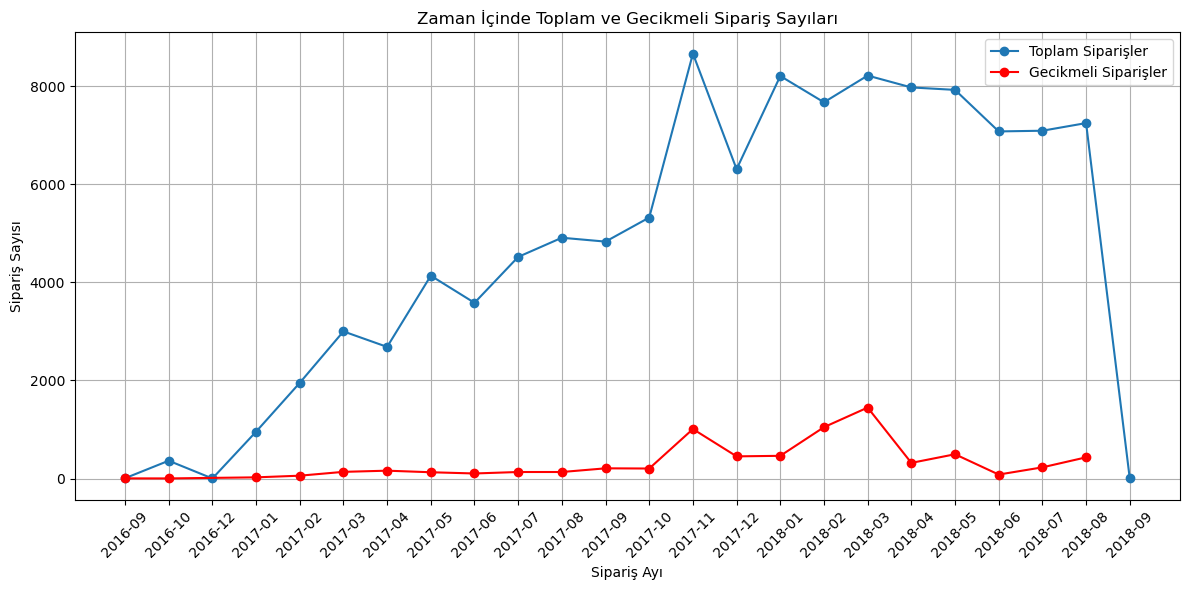

In [311]:
#3.2

# Tarihi normalize et (sadece ay bazında toplamak için)
fact_df['order_month'] = fact_df['order_purchase_timestamp'].dt.to_period('M')

# Aylık toplam sipariş sayısı
orders_per_month = fact_df.groupby('order_month')['order_id_pref'].count()

# Aylık gecikmeli sipariş sayısı
late_orders_per_month = fact_df[fact_df['is_late'] == 1].groupby('order_month')['order_id_pref'].count()

# Görselleştirme
plt.figure(figsize=(12,6))
plt.plot(orders_per_month.index.astype(str), orders_per_month.values, label="Toplam Siparişler", marker='o')
plt.plot(late_orders_per_month.index.astype(str), late_orders_per_month.values, label="Gecikmeli Siparişler", marker='o', color='red')

plt.title("Zaman İçinde Toplam ve Gecikmeli Sipariş Sayıları")
plt.xlabel("Sipariş Ayı")
plt.ylabel("Sipariş Sayısı")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

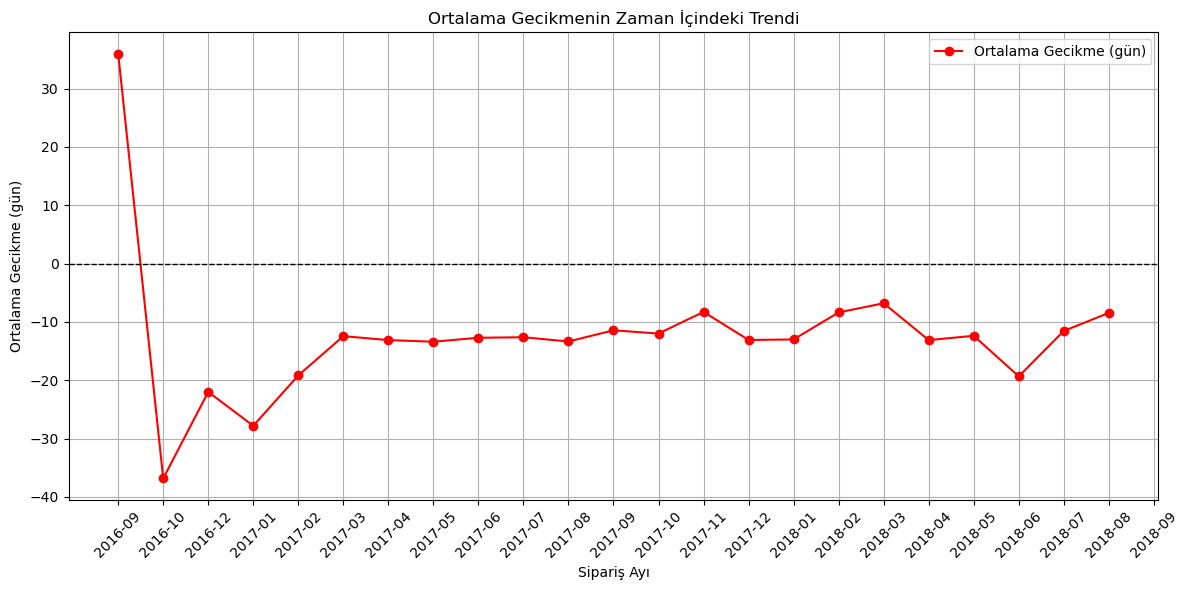

In [312]:
#3.3

# Ay bazında grupla ve ortalama gecikmenin hesaplanması
avg_delay_per_month = (
    fact_df.groupby(fact_df['order_purchase_timestamp'].dt.to_period('M'))['delay_days']
    .mean()
)

# Görselleştirme
plt.figure(figsize=(12,6))
plt.plot(avg_delay_per_month.index.astype(str), avg_delay_per_month.values, 
         marker='o', color='red', label='Ortalama Gecikme (gün)')

plt.title("Ortalama Gecikmenin Zaman İçindeki Trendi")
plt.xlabel("Sipariş Ayı")
plt.ylabel("Ortalama Gecikme (gün)")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # referans çizgisi (tahmin edilen gün)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2016-09’da ortalama gecikmenin çok yüksek çıkmasının birkaç olası nedeni var

a- Çok az sipariş var:

Olist veri setinde ilk siparişler 2016’nın ikinci yarısından başlıyor.

Eylül 2016’da sadece birkaç sipariş olabilir → bu birkaç siparişin gecikmesi ortalamayı çok şişirebilir.

b- Teslim tarihi eksik veya hatalı:

order_delivered_customer_date yanlış girilmiş (çok geç bir tarih) → fark (delay_days) aşırı büyümüş olabilir.

Örneğin 2016-09 siparişine 2017 teslim tarihi atanmış olabilir.

c- NaT → gecikme hesabında sorun:

Eğer tahmini veya gerçek teslim tarihi NaT iken yanlışlıkla gecikme hesaplandıysa, birkaç uç değer oluşabilir.

Ayrıca 2016-10'da yaklaşık 35 gün önceden teslim görünüyor. Bunun daayrıca incelenmesi gerekiyor.

In [ ]:
# Geç teslim kontrol
# 2016-09 siparişlerini filtrele
sep2016 = fact_df[fact_df['order_purchase_timestamp'].dt.to_period('M') == '2016-09']

# Kaç sipariş var?
print("Sipariş sayısı (2016-09):", sep2016.shape[0])

# Gecikme istatistikleri
print(sep2016['delay_days'].describe())

# Uç değerli siparişleri incele (örn. delay_days > 100)
print(sep2016[sep2016['delay_days'] > 100][[
    'order_id_pref','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date','delay_days'
]])

Sipariş sayısı (2016-09): 6
count    3.000
mean    36.000
std      0.000
min     36.000
25%     36.000
50%     36.000
75%     36.000
max     36.000
Name: delay_days, dtype: float64
Empty DataFrame
Columns: [order_id_pref, order_purchase_timestamp, order_delivered_customer_date, order_estimated_delivery_date, delay_days]
Index: []


#### Görünüm:
2016-09’da 6 sipariş var,

Bunlardan sadece 3 tanesinde delay_days hesaplanmış.

Hepsinde de gecikme = 36 gün

#### Yorum
İlk aylarda (2016’da) veri çok seyrek olduğu için ortalamalar yanıltıcı.

Bu yüzden EDA’da 2017 sonrasına odaklanmak daha sağlıklı olacaktır.

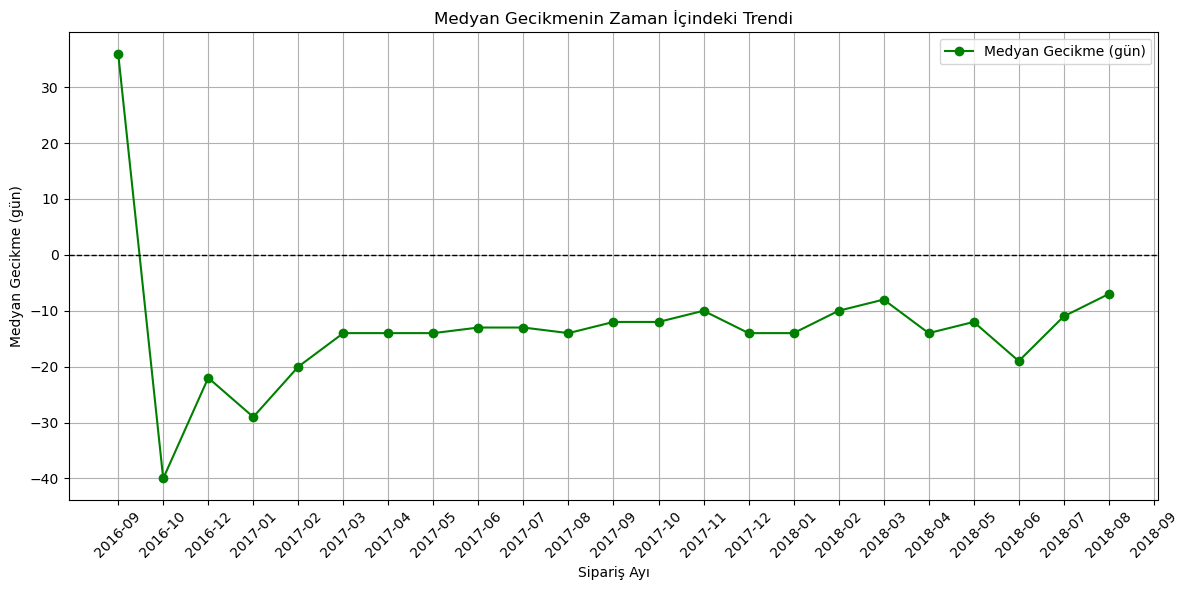

In [314]:
# Ay bazında medyan gecikme
median_delay_per_month = (
    fact_df.groupby(fact_df['order_purchase_timestamp'].dt.to_period('M'))['delay_days']
    .median()
)

# Çizim
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(median_delay_per_month.index.astype(str), median_delay_per_month.values, 
         marker='o', color='green', label='Medyan Gecikme (gün)')

plt.title("Medyan Gecikmenin Zaman İçindeki Trendi")
plt.xlabel("Sipariş Ayı")
plt.ylabel("Medyan Gecikme (gün)")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Genel olarak KArgo teslimatları 15 gün erken görünüyor, ayrıca 2016-10 noktasında 40 gün erken teslim var. normalde bu sayılar oldukça fazla, ancak burada bir işletme stratejisi olabilir. Şişirilimş Teslim tarihi ile erken teslim edildi görünüp müşteri memnuniyeti kazanmak istenmiş olabilir, veya en kötü şartlar hesaba katıldığı için teslim tarihi abartılmış olabilir. 

Ortalama delay_days: -12.030200733238956
Medyan delay_days: -13.0
       order_id_pref order_purchase_timestamp order_delivered_customer_date order_estimated_delivery_date  delay_days
2682        ORD40095      2018-03-06 09:47:07           2018-03-09 23:36:47                    2018-08-03    -147.000
2683        ORD40095      2018-03-06 09:47:07           2018-03-09 23:36:47                    2018-08-03    -147.000
87724       ORD15792      2017-02-07 18:01:15           2017-02-14 14:27:45                    2017-07-04    -140.000
105104      ORD57161      2018-02-06 20:44:56           2018-02-27 16:35:43                    2018-07-12    -135.000
85729       ORD86445      2017-05-23 22:28:36           2017-06-09 13:35:54                    2017-10-11    -124.000


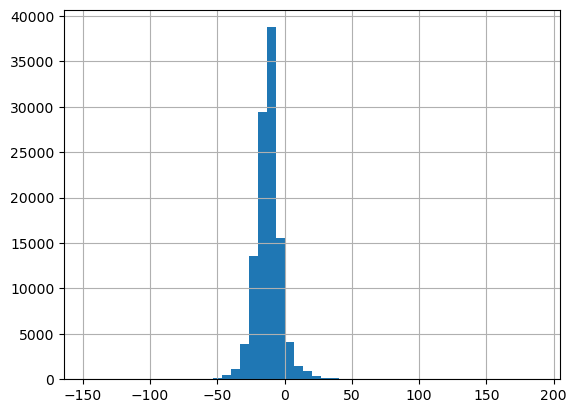

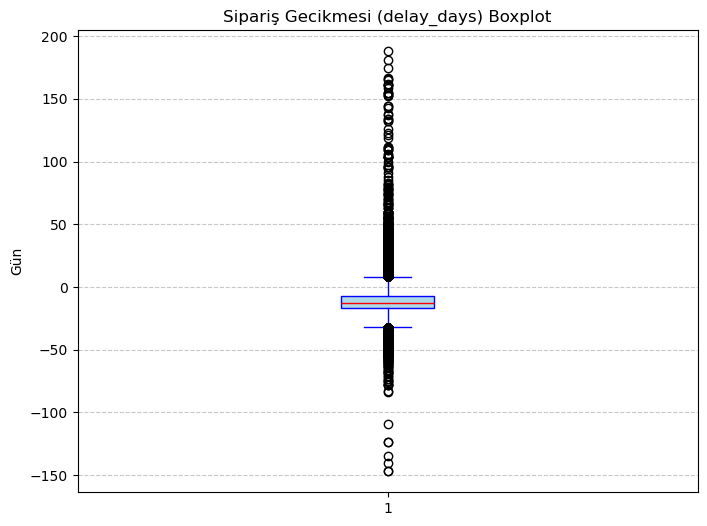

In [320]:
# Erken teslim (negatif delay) dağılımı
fact_df['delay_days'].hist(bins=50)

# Ortalama ve medyan erken teslim
print("Ortalama delay_days:", fact_df['delay_days'].mean())
print("Medyan delay_days:", fact_df['delay_days'].median())

# İlk 5 en erken teslim örneği
print(fact_df.nsmallest(5, 'delay_days')[[
    'order_id_pref','order_purchase_timestamp',
    'order_delivered_customer_date','order_estimated_delivery_date',
    'delay_days'
]])
plt.figure(figsize=(8,6))
plt.boxplot(fact_df['delay_days'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            whiskerprops=dict(color="blue"),
            capprops=dict(color="blue"))

plt.title("Sipariş Gecikmesi (delay_days) Boxplot")
plt.ylabel("Gün")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Histogram dağılımı 

In [315]:
oct2016 = fact_df[fact_df['order_purchase_timestamp'].dt.to_period('M') == '2016-10']

print("Sipariş sayısı (2016-10):", oct2016.shape[0])
print(oct2016['delay_days'].describe())

# Çok erken teslim olan siparişleri göster
print(oct2016[oct2016['delay_days'] < -20][[
    'order_id_pref',
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'delay_days'
]])

Sipariş sayısı (2016-10): 363
count   319.000
mean    -36.840
std      12.453
min     -76.000
25%     -45.500
50%     -40.000
75%     -31.000
max      18.000
Name: delay_days, dtype: float64
       order_id_pref order_purchase_timestamp order_delivered_customer_date order_estimated_delivery_date  delay_days
908         ORD94886      2016-10-07 10:52:22           2016-10-27 09:37:52                    2016-11-29     -33.000
909         ORD94886      2016-10-07 10:52:22           2016-10-27 09:37:52                    2016-11-29     -33.000
911         ORD68625      2016-10-07 17:37:49           2016-10-30 01:25:57                    2016-12-19     -50.000
1320        ORD54999      2016-10-04 19:01:13           2016-10-31 17:06:03                    2016-11-28     -28.000
1751         ORD4515      2016-10-05 15:17:57           2016-10-25 20:28:33                    2016-12-09     -45.000
2096        ORD49519      2016-10-08 20:28:48           2016-10-16 15:35:21                    2016-1